# Text Summarization using BiLSTM, Encoder-Decoder Architecture and Bert Transformer

Authors of the Project:

**Vaishnav Naik**

**Yashaurya Soni**

**Piyush Borakhade**

#Problem Statement

Customer reviews can be lengthy and detailed. Manually analysing these reviews, as you might guess, takes a long time. This is where ATML can be put to use to develop a short summary for lengthy reviews.

Our objective here is to generate a summary for the "Amazon Fine Food reviews" using BiLSTM Encoder-Decoder

#Project Pipeline

1. Understanding Text Summarization
2. Text pre-processing
3. Abstractive Text Summarization using BiLSTM, ENCODER-DECODER architecture and Bert Transformer

In [ ]:
  import kagglehub
import pandas as pd
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Embedding, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Download dataset
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
dataset_files = os.listdir(path)
csv_file = [file for file in dataset_files if file.endswith(".csv")][0]
data = pd.read_csv(os.path.join(path, csv_file))


#Text Preprocessing







Tokenized text and summary fields.
Padded sequences to uniform lengths.


*   Removed duplicate entries and NaN values.
*   Converted all text to lowercase.
*   Removed HTML tags and text within parentheses.
*   Eliminated special characters, numbers, and extra spaces.
*   Filtered out samples exceeding maximum sequence lengths.
*   Added special tokens (sostok, eostok) to summaries.
*   Tokenized text and summary fields.
*   Padded sequences to uniform lengths.







In [ ]:
# Data Cleaning
# Remove duplicates & NaN values
data.drop_duplicates(subset=['Text'], inplace=True)
data.dropna(axis=0, inplace=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r"\'s", "", text)  # Remove ('s)
    text = re.sub(r'\([^)]*\)', '', text)  # Remove text inside parentheses
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove special characters & numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove multiple spaces
    return text

In [ ]:
# Apply cleaning to 'Text' and 'Summary' columns
data['Text'] = data['Text'].apply(clean_text)
data['Summary'] = data['Summary'].apply(clean_text)

# Drop empty rows after cleaning
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

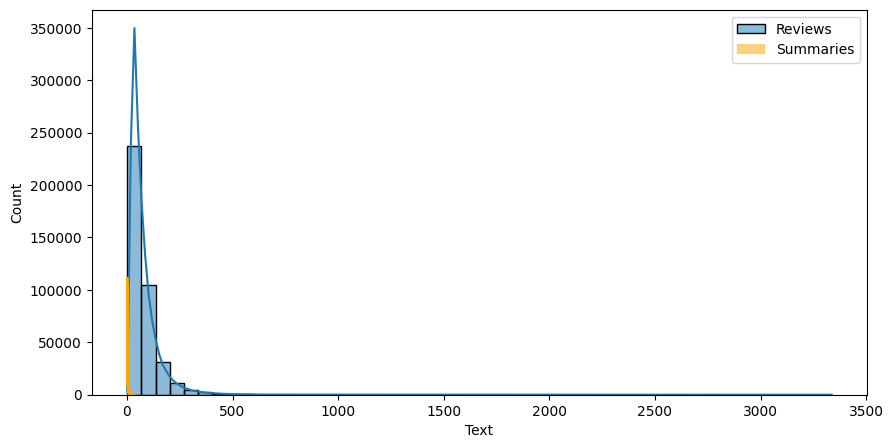

In [ ]:
# Sequence Length Analysis
text_lengths = data['Text'].apply(lambda x: len(x.split()))
summary_lengths = data['Summary'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(text_lengths, bins=50, kde=True, label='Reviews')
sns.histplot(summary_lengths, bins=50, kde=True, label='Summaries', color='orange')
plt.legend()
plt.show()

In [ ]:
# Define max lengths
max_text_len = 30
max_summary_len = 8

data = data[data['Text'].apply(lambda x: len(x.split()) <= max_text_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= max_summary_len)]

In [ ]:
# Add START & END tokens
data['Summary'] = data['Summary'].apply(lambda x: 'sostok ' + x + ' eostok')

<ipython-input-7-190f9a1da529>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Summary'] = data['Summary'].apply(lambda x: 'sostok ' + x + ' eostok')


In [ ]:

# Tokenization
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(data['Text'])
text_sequences = text_tokenizer.texts_to_sequences(data['Text'])
text_vocab_size = len(text_tokenizer.word_index) + 1

summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(data['Summary'])
summary_sequences = summary_tokenizer.texts_to_sequences(data['Summary'])
summary_vocab_size = len(summary_tokenizer.word_index) + 1

In [ ]:
# Padding
text_padded = pad_sequences(text_sequences, maxlen=max_text_len, padding='post')
summary_padded = pad_sequences(summary_sequences, maxlen=max_summary_len, padding='post')

# Train-Test Split
x_train, x_val, y_train, y_val = train_test_split(text_padded, summary_padded, test_size=0.1, random_state=42)

In [ ]:
# Embedding Layer
embedding_dim = 300
encoder_inputs = Input(shape=(max_text_len,))
embedding_layer = Embedding(input_dim=text_vocab_size, output_dim=embedding_dim, trainable=True)(encoder_inputs)

In [ ]:
# BiLSTM Encoder
encoder_lstm = Bidirectional(LSTM(300, return_state=True, dropout=0.4, recurrent_dropout=0.4))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(embedding_layer)
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_summary_len,))
decoder_embedding = Embedding(input_dim=summary_vocab_size, output_dim=embedding_dim, trainable=True)(decoder_inputs)
decoder_lstm = LSTM(600, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(summary_vocab_size, activation='softmax')
outputs = decoder_dense(decoder_outputs)

# Compile Model
model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define a proper max summary length
max_summary_len = 9

# Ensure padding before slicing
y_train_padded = pad_sequences(y_train, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val, maxlen=max_summary_len, padding='post')

# Verify the shape before training
print("Encoder input shape:", x_train.shape)
print("Decoder input shape:", y_train_padded[:, :-1].shape)
print("Target output shape:", y_train_padded[:, 1:].shape)

# Explicitly build the model with a sample input
# This ensures all variables are created on the first call
dummy_encoder_input = np.zeros((1, max_text_len))
dummy_decoder_input = np.zeros((1, max_summary_len-1))
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.build([(None, max_text_len), (None, max_summary_len-1)])

# Use tf.keras.backend.clear_session() to reset the session before training
tf.keras.backend.clear_session()

# Rebuild model (same architecture)
encoder_inputs = Input(shape=(max_text_len,))
embedding_layer = Embedding(input_dim=text_vocab_size, output_dim=embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm = Bidirectional(LSTM(300, return_state=True, dropout=0.4, recurrent_dropout=0.4))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(embedding_layer)
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(max_summary_len-1,))
decoder_embedding = Embedding(input_dim=summary_vocab_size, output_dim=embedding_dim, trainable=True)(decoder_inputs)
decoder_lstm = LSTM(600, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(summary_vocab_size, activation='softmax')
outputs = decoder_dense(decoder_outputs)

# Create a new model instance with correct input/output shapes
fixed_model = Model([encoder_inputs, decoder_inputs], outputs)
fixed_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model with corrected input shapes
history = fixed_model.fit(
    [x_train, y_train_padded[:, :-1]],  # Ensure decoder input is (None, 8)
    y_train_padded[:, 1:],  # Ensure target output is also (None, 8)
    epochs=20,
    batch_size=128,
    validation_data=([x_val, y_val_padded[:, :-1]], y_val_padded[:, 1:])
)

Encoder input shape: (71160, 30)
Decoder input shape: (71160, 8)
Target output shape: (71160, 8)
Epoch 1/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 187s 318ms/step - accuracy: 0.5885 - loss: 3.3095 - val_accuracy: 0.6459 - val_loss: 2.6027
Epoch 2/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 180s 323ms/step - accuracy: 0.6456 - loss: 2.5829 - val_accuracy: 0.6519 - val_loss: 2.4946
Epoch 3/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 202s 324ms/step - accuracy: 0.6541 - loss: 2.4651 - val_accuracy: 0.6561 - val_loss: 2.4294
Epoch 4/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 202s 324ms/step - accuracy: 0.6560 - loss: 2.4086 - val_accuracy: 0.6602 - val_loss: 2.3831
Epoch 5/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 201s 322ms/step - accuracy: 0.6601 - loss: 2.3530 - val_accuracy: 0.6621 - val_loss: 2.3416
Epoch 6/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 197s 314ms/step - accuracy: 0.6636 - loss: 2.3041 - val_accuracy: 0.6679 - val_loss: 2.2978
Epoch 7/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 179s 322ms/step - accuracy: 0.6683 - loss: 2.2497 - val_accuracy: 0.670

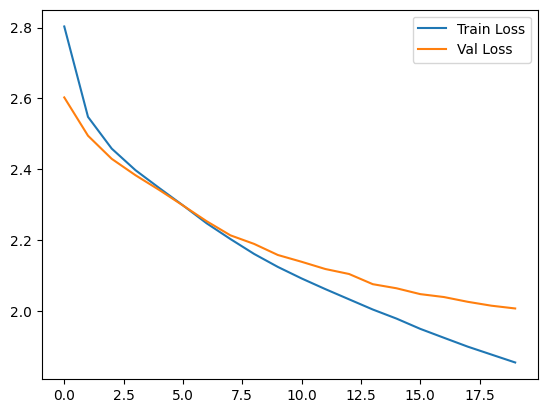

In [ ]:
# Diagnostic Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [ ]:
# Inference Setup
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(600,))
decoder_state_input_c = Input(shape=(600,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = summary_tokenizer.word_index['sostok']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = summary_tokenizer.index_word.get(sampled_token_index, '')
        decoded_sentence += ' ' + sampled_word
        if sampled_word == 'eostok' or len(decoded_sentence.split()) > max_summary_len:
            stop_condition = True
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

print("Model ready for inference!")


Model ready for inference!


In [ ]:
sample_text = "The food was great and the service was excellent. Highly recommended!"
sequence = text_tokenizer.texts_to_sequences([sample_text])
padded_sequence = pad_sequences(sequence, maxlen=max_text_len, padding='post')

# Generate summary
generated_summary = decode_sequence(padded_sequence)
print("Generated Summary:", generated_summary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Generated Summary:  great product eostok


In [ ]:
# Sample lengthy review text
sample_text = """I recently purchased this organic green tea, and I must say, I am thoroughly impressed.
From the moment I opened the package, I was greeted with a fresh and aromatic scent that was inviting.
Upon brewing, the tea had a beautiful golden hue and a rich flavor that wasn’t overpowering but had just the right balance of earthiness and freshness.
I have tried many brands in the past, but this one stands out because of its smoothness and lack of bitterness.
Additionally, the packaging is eco-friendly, which is a huge plus for me.
The tea bags are made from biodegradable material, and the resealable pouch keeps the tea fresh for a long time.
I drink this tea every morning, and it gives me a calming start to my day.
Highly recommended for anyone who loves a good quality tea that’s both organic and delicious!"""

# Preprocess the input text
sequence = text_tokenizer.texts_to_sequences([sample_text])
padded_sequence = pad_sequences(sequence, maxlen=max_text_len, padding='post')

# Generate summary
generated_summary = decode_sequence(padded_sequence)
print("Generated Summary:", generated_summary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Generated Summary:  great tea eostok


In [ ]:
# Sample lengthy review text
sample_text = """I ordered this product hoping for a good experience, but it turned out to be a complete disaster. The packaging was damaged when it arrived, and the product itself was stale. It had a weird smell, and the taste was awful. I tried contacting customer support, but they were extremely unhelpful and rude. They refused to replace or refund my order, making this a terrible shopping experience. I would not recommend this to anyone, and I will never buy from this brand again!"""

# Preprocess the input text
sequence = text_tokenizer.texts_to_sequences([sample_text])
padded_sequence = pad_sequences(sequence, maxlen=max_text_len, padding='post')

# Generate summary
generated_summary = decode_sequence(padded_sequence)
print("Generated Summary:", generated_summary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Generated Summary:  not what i expected eostok


# Hugging Face Transformers (BART model)

In [ ]:
from transformers import pipeline

# Load pre-trained summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def generate_summary(text, max_length=50, min_length=20):
    """Generates a summary using a pretrained transformer model."""
    summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

# ✅ Sample Positive Review
positive_review = """I recently purchased this organic green tea, and I must say, I am thoroughly impressed.
From the moment I opened the package, I was greeted with a fresh and aromatic scent that was inviting.
Upon brewing, the tea had a beautiful golden hue and a rich flavor that wasn’t overpowering but had just the right balance of earthiness and freshness.
I have tried many brands in the past, but this one stands out because of its smoothness and lack of bitterness.
Additionally, the packaging is eco-friendly, which is a huge plus for me.
The tea bags are made from biodegradable material, and the resealable pouch keeps the tea fresh for a long time.
I drink this tea every morning, and it gives me a calming start to my day.
Highly recommended for anyone who loves a good quality tea that’s both organic and delicious!"""

# ✅ Sample Negative Review
negative_review = """I ordered this product hoping for a good experience, but it turned out to be a complete disaster.
The packaging was damaged when it arrived, and the product itself was stale. It had a weird smell, and the taste was awful.
I tried contacting customer support, but they were extremely unhelpful and rude.
They refused to replace or refund my order, making this a terrible shopping experience.
I would not recommend this to anyone, and I will never buy from this brand again!"""

# 🔥 Generate Summaries
print("🔹 Positive Review Summary:", generate_summary(positive_review))
print("🔹 Negative Review Summary:", generate_summary(negative_review))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


🔹 Positive Review Summary: I drink this tea every morning, and it gives me a calming start to my day. The tea bags are made from biodegradable material, and the resealable pouch keeps the tea fresh for a long time.
🔹 Negative Review Summary: The packaging was damaged when it arrived, and the product itself was stale. I tried contacting customer support, but they were extremely unhelpful and rude. They refused to replace or refund my order, making this a terrible shopping experience.
